In [80]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)

In [81]:
import csv
import os
import pandas as pd
import numpy as np

path = os.path.join("../../data", "integrated_data_20251030_195505.csv")
df = pd.read_csv(path)

print("DataFrame shape (before cleaning):", df.shape)
print("Columns:", list(df.columns))

# Define required columns
numeric_columns = ['iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3', 
                   'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']

# First, convert columns to numeric, coercing errors to NaN
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Now drop rows with NaN in any numeric column (this catches both missing and invalid data)
df_clean = df.dropna(subset=numeric_columns)

print(f"\nRows removed: {len(df) - len(df_clean)}")
print(f"DataFrame shape (after cleaning): {df_clean.shape}")
print("\nFirst 5 rows after cleaning:")
print(df_clean.head())

# Drop non-numeric columns
df_numeric = df_clean.drop(columns=['timestamp', 'hand_label'], errors='ignore')

# Convert to numeric array (should work now)
data = df_numeric[numeric_columns].values.astype(np.float32)
print(f"\nNumeric data shape: {data.shape}")
print("First 5 rows of numeric data:")
print(data[:5])

DataFrame shape (before cleaning): (1000, 17)
Columns: ['timestamp', 'iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3', 'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky', 'hand_label']

Rows removed: 80
DataFrame shape (after cleaning): (920, 17)

First 5 rows after cleaning:
                    timestamp  iteration   env0  raw0   env1  raw1   env2  \
0  2025-10-30T19:57:11.124404          0  495.0  18.0  494.0  63.0  492.0   
1  2025-10-30T19:57:11.248486          1  494.0  18.0  494.0  63.0  494.0   
2  2025-10-30T19:57:11.331993          2  494.0  19.0  495.0  73.0  495.0   
4  2025-10-30T19:57:11.635704          4  495.0  18.0  493.0  68.0  499.0   
5  2025-10-30T19:57:11.740625          5  495.0  18.0  495.0  65.0  495.0   

   raw2   env3  raw3  thumb_tip  thumb_base   index  middle    ring   pinky  \
0  59.0  494.0  23.0     0.8696      0.4957  0.6387  0.7544  0.7679  0.6821   
1  38.0  494.0  23.0     0.8148      0.5007  0.6152  0.7285  0.7

In [82]:
sensor_columns = ['iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3']
finger_columns = ['thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']

actual_numeric_cols = list(df_numeric.select_dtypes(include=[np.number]).columns)

print(f"\nActual numeric columns: {actual_numeric_cols}")
# Find indices based on the actual data array
sensor_indices = [actual_numeric_cols.index(col) for col in sensor_columns if col in actual_numeric_cols]
finger_indices = [actual_numeric_cols.index(col) for col in finger_columns]


def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length, :]  
        y = data[i + seq_length, :]   
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Split data into 80% train, 20% test BEFORE creating sequences
split_ratio = 0.8
split_index = int(len(data) * split_ratio)

train_data = data[:split_index]
test_data = data[split_index:]

print(f"Total data points: {len(data)}")
print(f"Train data points: {len(train_data)}")
print(f"Test data points: {len(test_data)}")

# Create sequences separately for train and test
seq_length = 15
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Convert to PyTorch tensors
trainX = torch.tensor(X_train[:, :, sensor_indices], dtype=torch.float32)
trainY = torch.tensor(y_train[:, finger_indices], dtype=torch.float32)
testX = torch.tensor(X_test[:, :, sensor_indices], dtype=torch.float32)
testY = torch.tensor(y_test[:, finger_indices], dtype=torch.float32)

print(f"\ntrainX shape: {trainX.shape}")
print(f"trainY shape: {trainY.shape}")
print(f"testX shape: {testX.shape}")
print(f"testY shape: {testY.shape}")



Actual numeric columns: ['iteration', 'env0', 'raw0', 'env1', 'raw1', 'env2', 'raw2', 'env3', 'raw3', 'thumb_tip', 'thumb_base', 'index', 'middle', 'ring', 'pinky']
Total data points: 920
Train data points: 736
Test data points: 184

trainX shape: torch.Size([721, 15, 9])
trainY shape: torch.Size([721, 6])
testX shape: torch.Size([169, 15, 9])
testY shape: torch.Size([169, 6])


In [83]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take last time step
        return out, hn, cn

In [84]:
model = LSTMModel(input_dim=9, hidden_dim=200, layer_dim=16, output_dim=6)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [85]:
num_epochs = 100
h0, c0 = None, None
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs, h0, c0 = model(trainX, h0, c0)

    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    h0, c0 = h0.detach(), c0.detach()
    
    model.eval()
    with torch.no_grad():
        val_outputs, _, _ = model(testX, None, None)
        val_loss = criterion(val_outputs, testY)
        val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.1178
Epoch [20/100], Loss: 0.0987
Epoch [30/100], Loss: 0.0958
Epoch [40/100], Loss: 0.0954
Epoch [50/100], Loss: 0.0951
Epoch [60/100], Loss: 0.0948
Epoch [70/100], Loss: 0.0948
Epoch [80/100], Loss: 0.0948
Epoch [90/100], Loss: 0.0948
Epoch [100/100], Loss: 0.0948


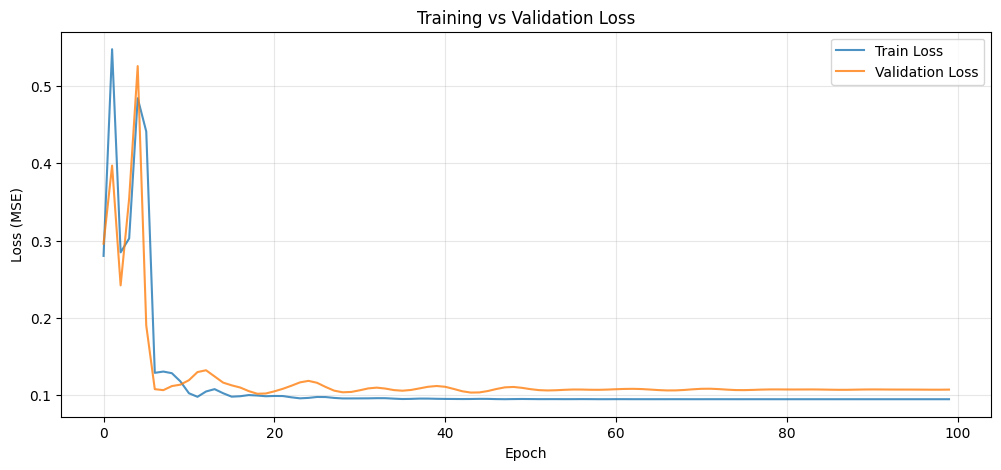


Final Train Loss: 0.0948
Final Validation Loss: 0.1072


In [86]:
# Plot training and validation losses
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Train Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal Train Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")

In [87]:
# Save the trained model
model_save_path = "../../models/lstm_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ../../models/lstm_model.pth


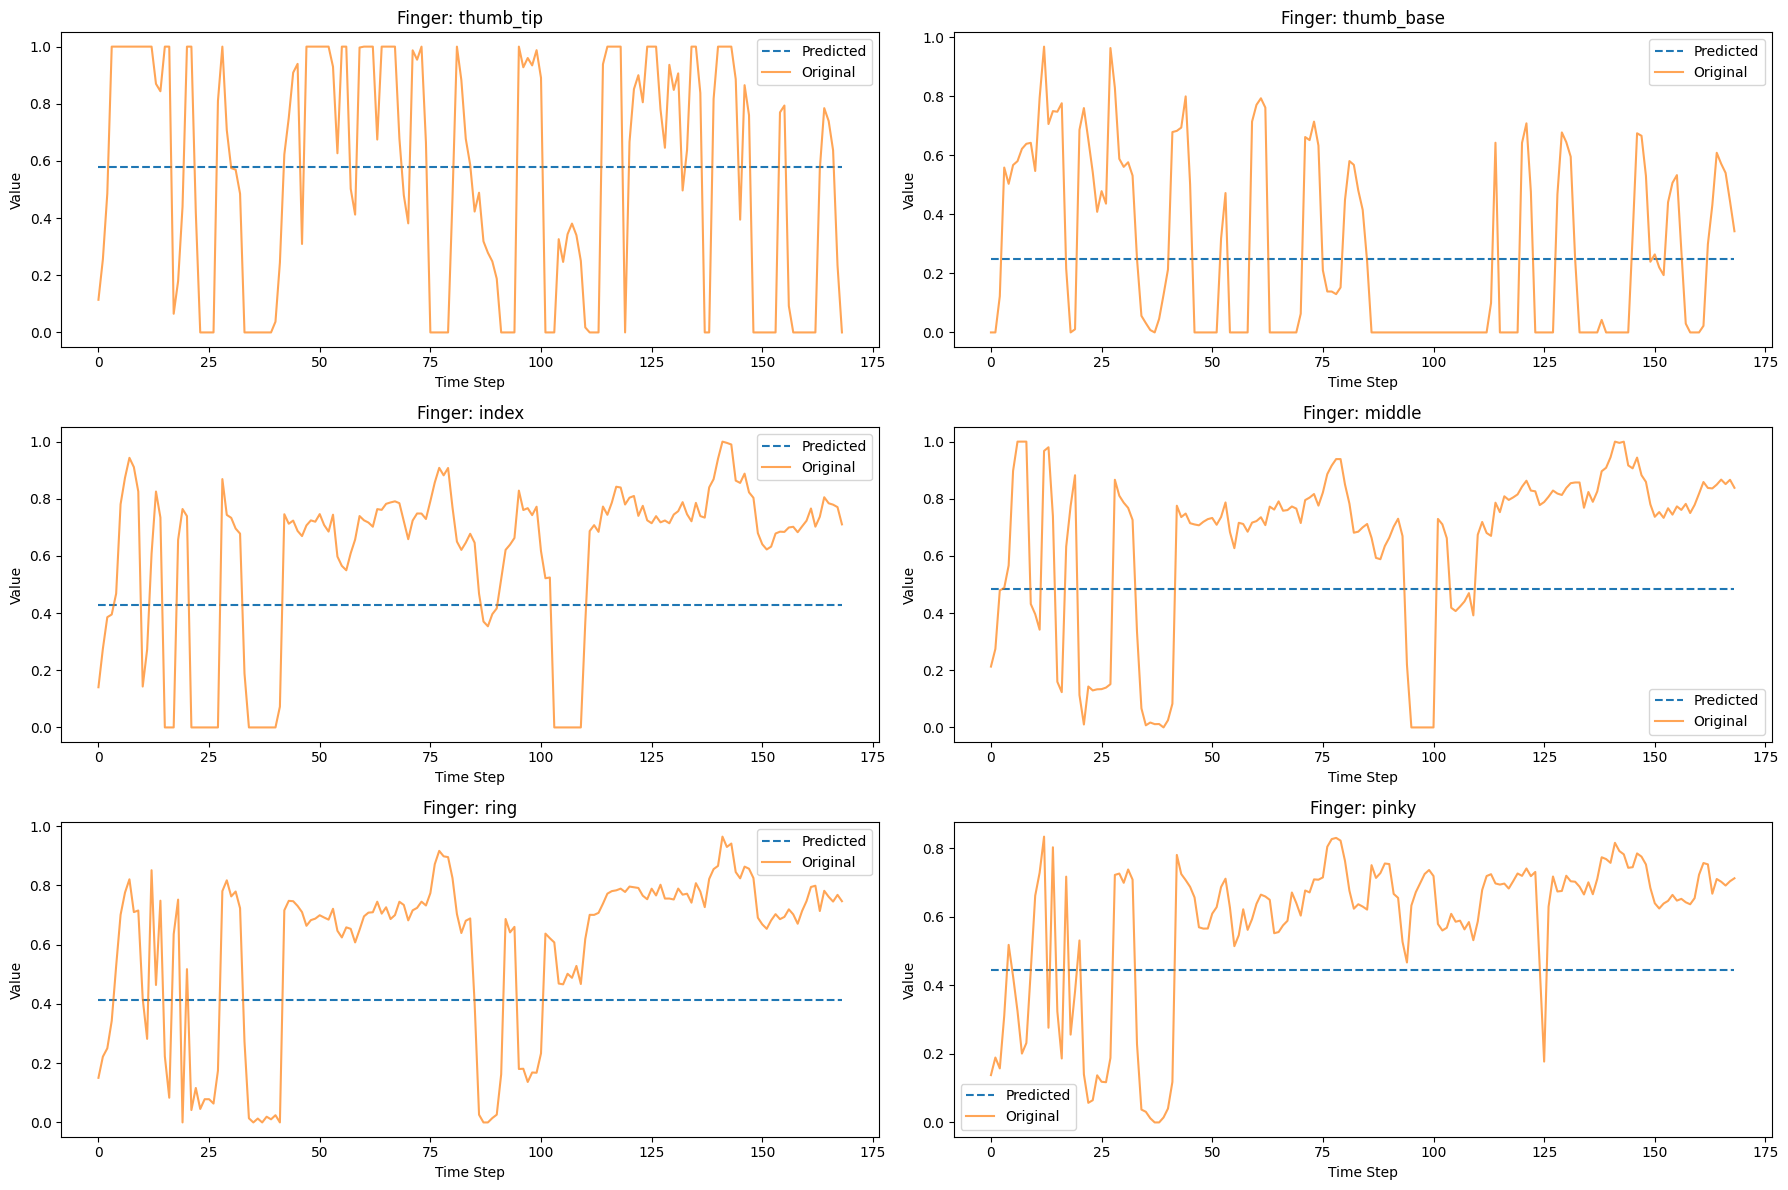

In [88]:
model.eval()
with torch.no_grad():
    predicted, _, _ = model(testX, None, None)


predicted = predicted.detach().numpy() 
original = testY.numpy()  


# Create plots for each finger
plt.figure(figsize=(18, 12))
for i, finger in enumerate(finger_columns):
    plt.subplot(3, 2, i + 1)  # Create a subplot for each finger
    plt.plot(predicted[:, i], label='Predicted', linestyle='--')
    plt.plot(original[:, i], label='Original', alpha=0.7)
    plt.title(f"Finger: {finger}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.show()